In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from paraspec.base import IR12SpeciationModel

%matplotlib inline

# Run the model in a static landscape

In [2]:
length = (250, 250)
spacing = (1, 1)

X, Y = np.meshgrid(*[np.arange(0, l+s, s)
                     for l, s in zip(length, spacing)])

r = np.random.RandomState(0)

elevation = X * 10 + r.rand(*Y.shape)

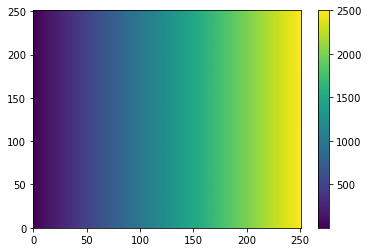

In [3]:
plt.pcolormesh(elevation)
plt.colorbar();

# Initial parameters for speciation models

In [4]:
pop_size = 100
num_gen = 1000
plot_gen_by = np.arange(0, num_gen, 100)
dt = 1e0

## Speciation model without competition

In [5]:
def mode1_run():
    model1 = IR12SpeciationModel(X, Y, pop_size, nb_radius=50, car_cap=50,
                                 sigma_w=0.2, sigma_mov=5, sigma_mut=0.05,
                                 lifespan=1, mut_prob=0.05, random_seed=1234)
    model1.initialize([[0.5, 0.5]])
    dfs1 = []
    for step in range(num_gen):
        model1.evaluate_fitness(elevation, elevation.min(), elevation.max(), dt)
        dfs1.append(model1.to_dataframe())
        model1.update_population(dt)
    return pd.concat(dfs1)
#%timeit mode1_run()

In [6]:
population1 = mode1_run()
population1

,step,time,dt,id,parent,x,y,r_d,opt_trait,fitness,n_offspring,trait_0
0,0,0.0,0.0,0,0,74.460023,186.818327,4.166667,0.306323,0.625700,3,0.500000
1,0,0.0,0.0,1,1,154.790254,0.517769,5.000000,0.613889,0.850327,4,0.500000
2,0,0.0,0.0,2,2,75.439357,202.339080,3.571429,0.309980,0.636770,2,0.500000
3,0,0.0,0.0,3,3,43.711613,201.702223,3.125000,0.192357,0.306343,1,0.500000
4,0,0.0,0.0,4,4,123.876299,13.633167,7.142857,0.496127,0.999812,7,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
479,999,999.0,0.0,485579,485095,133.253481,196.599329,0.961538,0.530413,0.999871,1,0.533631
480,999,999.0,0.0,485580,485096,129.077933,165.920250,1.162791,0.515332,0.908205,1,0.427566
481,999,999.0,0.0,485581,485097,122.887315,199.787911,0.943396,0.492286,0.998660,1,0.502643
482,999,999.0,0.0,485582,485098,122.595358,235.492050,1.041667,0.492394,0.949577,1,0.428059


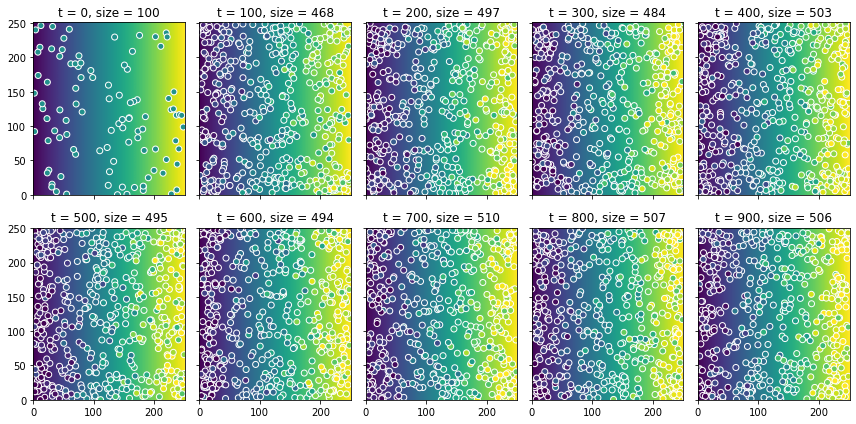

In [7]:
fig1, axes1 = plt.subplots(nrows=2, ncols=5, sharex='col', sharey='row',figsize=(12, 6))
for ax, print_step in zip(axes1.ravel(), plot_gen_by):
    pop = population1.groupby('step').get_group(print_step)
    ax.pcolormesh(elevation)
    ax.scatter(pop.x, pop.y, c=pop.trait_0, edgecolor='w',vmin=0, vmax=1)
    ax.set_title(f't = {print_step}, size = {len(pop)}')
fig1.tight_layout()

Text(0.5, 0, 'Time (generations)')

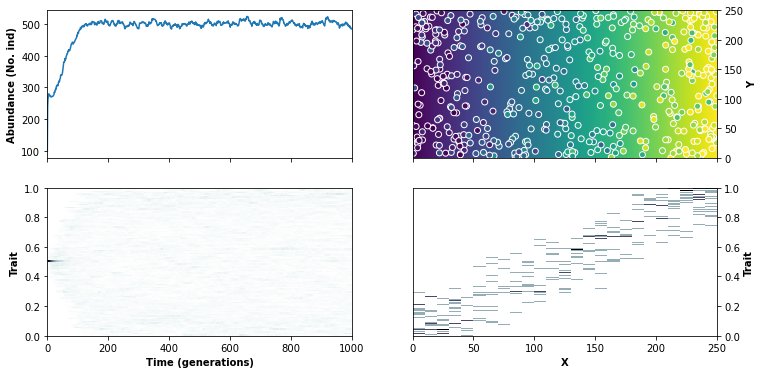

In [8]:
fig2, axs2 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
axs2[0,0].plot(population1.groupby('step').size())
h,xedge,yedge,_=axs2[1,0].hist2d(x=population1['step'], y=population1['trait_0'], 
                                 range=((0, num_gen), (0, 1)), 
                                 bins=(num_gen, 100), cmap='bone_r')
axs2[0, 1].pcolormesh(elevation)
axs2[0, 1].scatter(population1['x'].loc[population1['step']==max(population1['step'])], 
                   population1['y'].loc[population1['step']==max(population1['step'])], 
                   c=population1['trait_0'].loc[population1['step']==max(population1['step'])],
                   edgecolor='w',vmin=0, vmax=1)
h,xedge,yedge,_=axs2[1,1].hist2d(x=population1['x'].loc[population1['step']==max(population1['step'])], 
                                 y=population1['trait_0'].loc[population1['step']==max(population1['step'])], 
                                 range=((0, X.max()), (0, 1)),
                                 bins=(25, 250), cmap='bone_r')
axs2[0, 1].yaxis.set_label_position("right")
axs2[0, 1].yaxis.tick_right()
axs2[1, 1].yaxis.set_label_position("right")
axs2[1, 1].yaxis.tick_right()
axs2[0, 1].set_ylabel('Y', weight='bold')
axs2[0, 0].set_ylabel('Abundance (No. ind)', weight='bold')
axs2[1, 1].set_ylabel('Trait', weight='bold')
axs2[1, 0].set_ylabel('Trait', weight='bold')
axs2[1, 1].set_xlabel('X', weight='bold')
axs2[1, 0].set_xlabel('Time (generations)', weight='bold')

## Speciation model with competition

In [9]:
from paraspec.base import DD03SpeciationModel

In [10]:
def model2_run():
    model2 = DD03SpeciationModel(X, Y, pop_size, car_cap_max=500, sigma_opt_trait=0.2, 
                                 mut_prob=0.05, sigma_mut=0.05, sigma_mov=5, sigma_comp_trait=0.9, 
                                 sigma_comp_dist=0.1, random_seed=1234)
    model2.initialize([[0.5, 0.5]])
    dfs2 = []
    dfs2.append(model2.to_dataframe())
    for step in range(num_gen):
        model2.update(elevation, elevation.min(), elevation.max(), dt)
        dfs2.append(model2.to_dataframe())  
    return pd.concat(dfs2)
#%timeit model2_run()

In [11]:
population2 = model2_run()
population2

,step,time,dt,id,parent,x,y,trait_0
0,0,0.0,0.0,0,0,74.460023,186.818327,0.500000
1,0,0.0,0.0,1,1,154.790254,0.517769,0.500000
2,0,0.0,0.0,2,2,75.439357,202.339080,0.500000
3,0,0.0,0.0,3,3,43.711613,201.702223,0.500000
4,0,0.0,0.0,4,4,123.876299,13.633167,0.500000
...,...,...,...,...,...,...,...,...
614,1000,1000.0,1.0,64470,64340,105.187180,31.600132,0.373507
615,1000,1000.0,1.0,64471,64341,167.042468,125.872085,0.791899
616,1000,1000.0,1.0,64472,64368,136.413190,32.254111,0.686168
617,1000,1000.0,1.0,64473,64371,61.767270,7.791585,0.126241


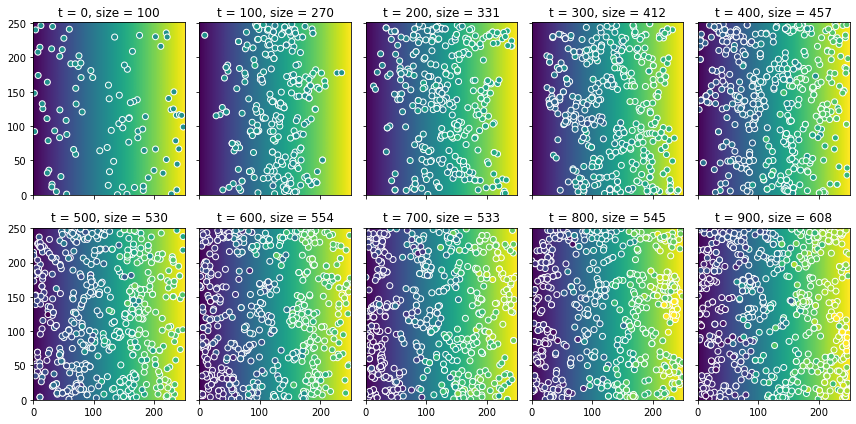

In [12]:
fig3, axes3 = plt.subplots(nrows=2, ncols=5, sharex='col', sharey='row',figsize=(12, 6))
for ax, print_step in zip(axes3.ravel(), plot_gen_by):
    pop = population2.groupby('step').get_group(print_step)
    ax.pcolormesh(elevation)
    ax.scatter(pop.x, pop.y, c=pop.trait_0, edgecolor='w',vmin=0, vmax=1)
    ax.set_title(f't = {print_step}, size = {len(pop)}')
fig3.tight_layout()

Text(0.5, 0, 'Time (generations)')

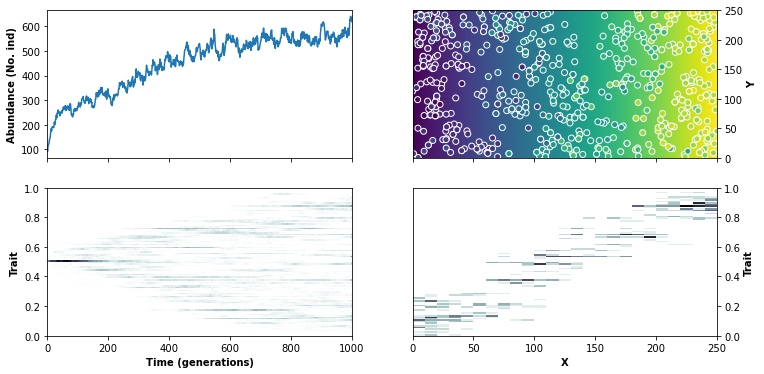

In [13]:
fig4, axs4 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
axs4[0,0].plot(population2.groupby('step').size())
h,xedge,yedge,_=axs4[1,0].hist2d(x=population2['step'], y=population2['trait_0'], 
                               range=((0, num_gen), (0, 1)), bins=(num_gen, 100), cmap='bone_r')
axs4[0, 1].pcolormesh(elevation)
axs4[0, 1].scatter(population2['x'].loc[population2['step']==max(population2['step'])], 
                      population2['y'].loc[population2['step']==max(population2['step'])], 
                      c=population2['trait_0'].loc[population2['step']==max(population2['step'])], 
                      edgecolor='w',vmin=0, vmax=1)
h,xedge,yedge,_=axs4[1,1].hist2d(x=population2['x'].loc[population2['step']==max(population2['step'])], 
                                 y=population2['trait_0'].loc[population2['step']==max(population2['step'])], 
                               range=((0, X.max()), (0, 1)), bins=(25, 100), cmap='bone_r')
axs4[0, 1].yaxis.set_label_position("right")
axs4[0, 1].yaxis.tick_right()
axs4[1, 1].yaxis.set_label_position("right")
axs4[1, 1].yaxis.tick_right()
axs4[0, 1].set_ylabel('Y', weight='bold')
axs4[0, 0].set_ylabel('Abundance (No. ind)', weight='bold')
axs4[1, 1].set_ylabel('Trait', weight='bold')
axs4[1, 0].set_ylabel('Trait', weight='bold')
axs4[1, 1].set_xlabel('X', weight='bold')
axs4[1, 0].set_xlabel('Time (generations)', weight='bold')